#  <font color='#FFE15D'><b>💎 Project 4: Speech Recognition 🔬</b></font>
<img src="http://dl.howsam.org/Deep-Catalyst/rocket-200px.png" alt="Deep Catalyst"/>

Deep Catalyst Course [webpage](https://howsam.org/downloads/deep-catalyst/)

by Howsam AI Academy (www.howsam.org)

# 🔴 **Environment Setup**

## 🟠  **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 🟠 Perhaps you may need to install the `torchmetrics` library. To do so, you can execute this cell.

In [2]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.0 MB/s eta 0:00:00


In [3]:
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.6 MB/s eta 0:00:00


# 🔴 **Import Libs**

In [6]:
import csv
import os
import glob
from pathlib import Path
from typing import Tuple, Union
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
import torchaudio.functional as AF
from torchaudio._internal import download_url_to_file
from torchaudio.datasets.utils import _extract_tar

from torcheval.metrics import WordErrorRate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics.aggregation import MeanMetric
from tqdm import tqdm
import string
import random

from IPython.display import Audio

In [5]:
!python --version

Python 3.10.12


In [7]:
for lib in [np, pd, torch, torchaudio]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
pandas --> 1.5.3
torch --> 2.1.0+cu118
torchaudio --> 2.1.0+cu118


# 🔴 **Utils**

In [8]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [9]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [10]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(T.AmplitudeToDB()(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [11]:
def num_trainable_params(model):
    nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
    return nums

In [12]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

# 🔴 **Arguments**

In [85]:
seed = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
root_dir = './data'
batch_size = 16
num_classes = 40
sample_rate = 22050
n_fft = 400
hop_length = 160
n_mels = 64
in_channels = 1
max_seq_len = 200
out_channels = [64, 128, max_seq_len]
kernel_size = 3
padding = 1
stride = 2
num_layers = 2
num_heads = 4
max_waveform_len = 222705
dim_feedforward = 512

# 🔴 **Dataset**

## 🟠 Load the Dataset

Load the LJ Speech dataset.

Check the structure of the data, such as the waveform samples, corresponding






In [ ]:
dataset = datasets.LJSPEECH(root=root_dir,
                            url='https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2',
                            download=True)

In [17]:
print(f'Number of short audio clips: {len(dataset)}')

Number of short audio clips: 13100


In [18]:
dataset[1803]

(tensor([[-0.0013, -0.0008, -0.0005,  ..., -0.0007, -0.0009, -0.0010]]),
 22050,
 'As the law stood since the passing of the 9th George IV. c. 40, any two justices might remove a prisoner found to be insane, either on commitment',
 'As the law stood since the passing of the ninth George the fourth c. forty, any two justices might remove a prisoner found to be insane, either on commitment')

### 🟡 **Load Audio** 🎵

In [19]:
waveform, sample_rate, transcript, normalized_transcript = dataset[15]
print('waveform:\n', waveform)
print('waveform shape:\n', waveform.shape)
print('sample_rate:\n', sample_rate)
print('normalized_transcript:\n', normalized_transcript)

waveform:
 tensor([[-0.0011, -0.0011, -0.0011,  ...,  0.0004,  0.0003,  0.0002]])
waveform shape:
 torch.Size([1, 116125])
sample_rate:
 22050
normalized_transcript:
 The Middle Ages brought calligraphy to perfection, and it was natural therefore


In [20]:
Audio(waveform.numpy(), rate=sample_rate)

Sample Rate: 22050
Shape: (1, 116125)
Dtype: torch.float32
 - Max:      0.737
 - Min:     -0.607
 - Mean:     0.000
 - Std Dev:  0.100

tensor([[-0.0011, -0.0011, -0.0011,  ...,  0.0004,  0.0003,  0.0002]])



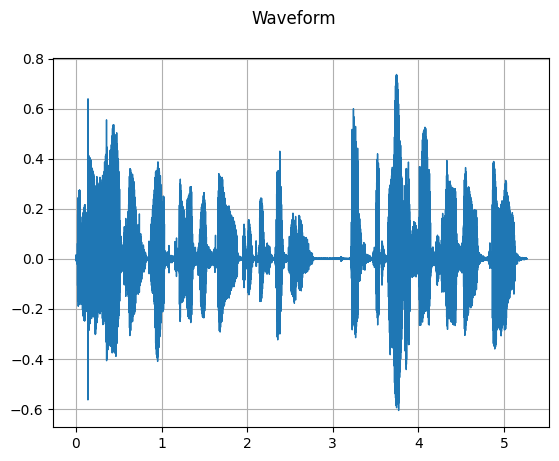

In [21]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)

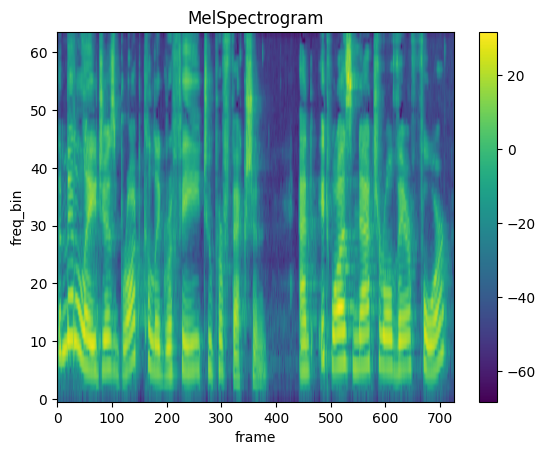

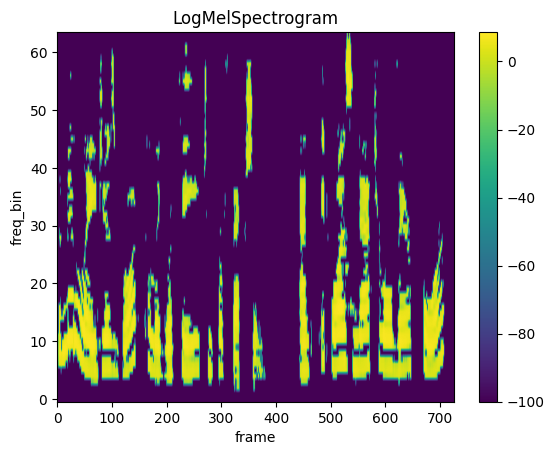

In [22]:
mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels)
melspec = mel_spectrogram(waveform)
log_mel_spec = torch.log(mel_spectrogram(waveform))

plot_spectrogram(melspec[0], title='MelSpectrogram')
plot_spectrogram(log_mel_spec[0], title='LogMelSpectrogram')

## 🟠 Dataset Preparation

Use Source code of [torchaudio.datasets.ljspeech](https://pytorch.org/audio/stable/_modules/torchaudio/datasets/ljspeech.html#LJSPEECH) and Split the dataset to training, validation, and testing sets based on provided text files in data folder.

In [23]:
_RELEASE_CONFIGS = {
    "release1": {
        "folder_in_archive": "wavs",
        "url": "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2",
        "checksum": "be1a30453f28eb8dd26af4101ae40cbf2c50413b1bb21936cbcdc6fae3de8aa5",
    }
}

class LJSPEECH(Dataset):
    """*LJSpeech-1.1* :cite:`ljspeech17` dataset.

    Args:
        root (str or Path): Path to the directory where the dataset is found or downloaded.
        url (str, optional): The URL to download the dataset from.
            (default: ``"https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"``)
        folder_in_archive (str, optional):
            The top-level directory of the dataset. (default: ``"wavs"``)
        download (bool, optional):
            Whether to download the dataset if it is not found at root path. (default: ``False``).
    """

    def __init__(
        self,
        root: Union[str, Path],
        url: str = _RELEASE_CONFIGS["release1"]["url"],
        folder_in_archive: str = _RELEASE_CONFIGS["release1"]["folder_in_archive"],
        split_file: str = None,
        download: bool = False

    ) -> None:

        self._parse_filesystem(root, url, folder_in_archive, split_file, download)

    def _parse_filesystem(self, root: str, url: str, folder_in_archive: str, split_file: str, download: bool) -> None:
        root = Path(root)

        basename = os.path.basename(url)
        archive = root / basename

        basename = Path(basename.split(".tar.bz2")[0])
        folder_in_archive = basename / folder_in_archive

        self._path = root / folder_in_archive
        self._metadata_path = root / basename / "metadata.csv"

        if download:
            if not os.path.isdir(self._path):
                if not os.path.isfile(archive):
                    checksum = _RELEASE_CONFIGS["release1"]["checksum"]
                    download_url_to_file(url, archive, hash_prefix=checksum)
                _extract_tar(archive)
        else:
            if not os.path.exists(self._path):
                raise RuntimeError(
                    f"The path {self._path} doesn't exist. "
                    "Please check the ``root`` path or set `download=True` to download it"
                )

        # read {train, valid, test} files
        with open(split_file) as f:
            self.split_samples = f.read().strip().split("\n")

        with open(self._metadata_path, "r", newline="") as metadata:
            flist = csv.reader(metadata, delimiter="|", quoting=csv.QUOTE_NONE)
            self._flist = list(flist)
            self._flist = [item for sample in self.split_samples for item in self._flist if item[0] == sample]


    def __getitem__(self, n: int) -> Tuple[torch.Tensor, int, str, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            Tuple of the following items;

            Tensor:
                Waveform
            int:
                Sample rate
            str:
                Transcript
            str:
                Normalized Transcript
        """
        line = self._flist[n]
        fileid, transcript, normalized_transcript = line
        fileid_audio = self._path / (fileid + ".wav")

        # load audio
        waveform, sample_rate = torchaudio.load(fileid_audio)

        return (
            waveform,
            sample_rate,
            transcript,
            normalized_transcript,
        )

    def __len__(self) -> int:
        return len(self._flist)

In [26]:
train_set = LJSPEECH(root=root_dir, split_file='./data/train.txt')
valid_set = LJSPEECH(root=root_dir, split_file='./data/valid.txt')
test_set = LJSPEECH(root=root_dir, split_file='./data/test.txt')

In [27]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

In [28]:
train_set[5000]

(tensor([[0.0004, 0.0004, 0.0002,  ..., 0.0009, 0.0013, 0.0000]]),
 22050,
 'It is suggested that an organization shorn of its power to investigate all the possibilities of danger to the President',
 'It is suggested that an organization shorn of its power to investigate all the possibilities of danger to the President')

## 🟠 EDA

Total Clips	13,100

Total Words	225,715

Total Characters	1,308,678

Total Duration	23:55:17

Mean Clip Duration	6.57 sec

Min Clip Duration	1.11 sec

Max Clip Duration	10.10 sec

Mean Words per Clip	17.23

Distinct Words	13,821

In [29]:
file_path = os.path.join(root_dir, "LJSpeech-1.1/", "metadata.csv")

df_metadata = pd.read_csv(file_path, sep='|', header=None)
df_metadata.columns = ['waveform_id', 'transcript', 'normalized_transcript']
df_metadata

,waveform_id,transcript,normalized_transcript
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
...,...,...,...
13095,LJ050-0274,made certain recommendations which it believes...,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...,with the active cooperation of the responsible...


In [30]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   waveform_id            13100 non-null  object
 1   transcript             13100 non-null  object
 2   normalized_transcript  13084 non-null  object
dtypes: object(3)
memory usage: 307.2+ KB


In [31]:
# basic statistics
num_samples = len(df_metadata)
print(f"Total Clips: {num_samples}")

Total Clips: 13100


In [37]:
# text analysis
text_lengths = [len(entry) for entry in df_metadata['transcript']]
print(f"Average text length: {sum(text_lengths) / num_samples:.2f}")
print(f"Max text length: {max(text_lengths)}")
print(f"Min text length: {min(text_lengths)}")
print()

total_words = 0
for entry in df_metadata['transcript']:
    words = entry.split()
    total_words += len(words)

print(f"Total words: {total_words}")

Average text length: 98.47
Max text length: 331
Min text length: 5

Total words: 221382


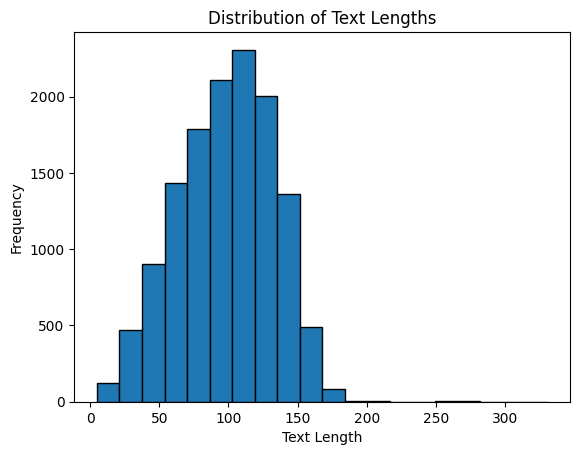

In [38]:
# text length distribution
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [42]:
# calculate duration time of 1000 random Clip
wavs_path = os.path.join(root_dir, "LJSpeech-1.1/wavs/*.wav")
paths = glob.glob(wavs_path)
num_random_clip = 1000
random_path = random.sample(paths, num_random_clip)

durations = []
for path in random_path:
    waveform, sampling_rate = torchaudio.load(path)
    duration = waveform.size(1) / sample_rate
    durations.append(duration)

durations_sum = sum(durations)
durations_avg = durations_sum / len(durations)
durations_min = min(durations)
durations_max = max(durations)

print(f"durations_sum: {durations_sum:.2f} sec.")
print(f"durations_avg: {durations_avg:.2f}  sec.")
print(f"durations_min: {durations_min:.2f}  sec.")
print(f"durations_max: {durations_max:.2f}  sec.")

durations_sum: 6496.47 sec.
durations_avg: 6.50  sec.
durations_min: 1.11  sec.
durations_max: 10.10  sec.


## 🟠 Dataloader

In [40]:
# define the vocabulary
symbols  = "-!'(),.:;?_ " + string.ascii_lowercase
symbols_to_index = {symbol: idx for idx, symbol in enumerate(symbols, 3)}
symbols_to_index['<OOV>'] = 0
symbols_to_index['<'] = 1 # SOS
symbols_to_index['>'] = 2 # EOS
symbols_to_index

{'-': 3,
 '!': 4,
 "'": 5,
 '(': 6,
 ')': 7,
 ',': 8,
 '.': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 '_': 13,
 ' ': 14,
 'a': 15,
 'b': 16,
 'c': 17,
 'd': 18,
 'e': 19,
 'f': 20,
 'g': 21,
 'h': 22,
 'i': 23,
 'j': 24,
 'k': 25,
 'l': 26,
 'm': 27,
 'n': 28,
 'o': 29,
 'p': 30,
 'q': 31,
 'r': 32,
 's': 33,
 't': 34,
 'u': 35,
 'v': 36,
 'w': 37,
 'x': 38,
 'y': 39,
 'z': 40,
 '<OOV>': 0,
 '<': 1,
 '>': 2}

In [68]:
def text_to_char(normalized_transcript):

    text_lengths, text_indices = [], []
    for text in normalized_transcript:
        text = '<' + text + '>'
        text_lengths.append(len(text))
        text_indices.append(torch.LongTensor([symbols_to_index.get(char.lower(), symbols_to_index['<OOV>']) for char in text]))

    return torch.tensor(text_lengths), (text_indices)

text_to_char(['Speech To Text!', 'Project four: Speech Recognition'])

(tensor([17, 34]),
 [tensor([ 1, 33, 30, 19, 19, 17, 22, 14, 34, 29, 14, 34, 19, 38, 34,  4,  2]),
  tensor([ 1, 30, 32, 29, 24, 19, 17, 34, 14, 20, 29, 35, 32, 10, 14, 33, 30, 19,
          19, 17, 22, 14, 32, 19, 17, 29, 21, 28, 23, 34, 23, 29, 28,  2])])

In [69]:
def collate_fn(batch):

    waveforms = [metadata[0][0] for metadata in batch]

    # pad waveforms to the length of the longest sequence
    waveforms_padded = pad_sequence(waveforms, batch_first=True)

    # convert text to tensor and get lengths
    normalized_transcript = [metadata[3] for metadata in batch]
    text_lengths, text_indices = text_to_char(normalized_transcript)

    texts_padded = pad_sequence([torch.cat((seq, torch.zeros(max_seq_len - len(seq)))) for seq in text_indices], batch_first=True)

    return waveforms_padded, texts_padded, text_lengths

In [70]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size, shuffle=False, collate_fn=collate_fn)

In [71]:
waveforms_padded, texts_padded, text_lengths = next(iter(train_loader))
waveforms_padded.shape, texts_padded.shape, text_lengths

(torch.Size([16, 209309]),
 torch.Size([16, 200]),
 tensor([ 72,  23,  37, 106,  43, 124, 103, 136,  45, 106,  95, 105,  86, 109,
          48,  83]))

# 🔴 **Model**

In [72]:
class LogMelSpectrogram(nn.Module):
    def __init__(self, sample_rate, n_fft, hop_length, n_mels):
        super().__init__()
        self.mel_spec = T.MelSpectrogram(sample_rate=sample_rate,
                                   n_fft=n_fft,
                                   hop_length=hop_length,
                                   n_mels=n_mels)

    def forward(self, waveform):
        return torch.log(self.mel_spec(waveform.unsqueeze(1)) + 1e-9)

In [73]:
class FeatureEmbedding(nn.Module):
    def __init__(self, in_channels=1, out_channels=[64, 128, 200], kernel_size=(3, 3), padding=(1, 1), stride=(2, 2)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=out_channels[0], kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels[0])
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=stride)
        self.conv2 = nn.Conv2d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels[1])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=stride)
        self.conv3 = nn.Conv2d(in_channels=out_channels[1], out_channels=out_channels[2], kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(out_channels[2])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=stride)

    def forward(self, x):
        x = self.bn1(self.conv1(x)).relu()
        x = self.pool1(x)
        x = self.bn2(self.conv2(x)).relu()
        x = self.pool2(x)
        x = self.bn3(self.conv3(x)).relu()
        x = self.pool3(x)
        return x

In [74]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_layers, num_heads, dim_feedforward=512, batch_first=True):
        super().__init__()
        self.transformer = nn.Transformer(d_model=input_size,
                                          nhead=num_heads,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          dim_feedforward=dim_feedforward,
                                          batch_first=batch_first)

    def forward(self, src, tgt):
        outputs = self.transformer(src, tgt)
        return outputs

In [75]:
class SpeechToTextModel(nn.Module):
    def __init__(self, sample_rate, n_fft, hop_length, n_mels,
                 in_channels, out_channels, kernel_size, padding, stride,
                 input_size, num_layers, num_heads, num_classes, batch_first=True):
        super().__init__()

        self.log_mel_spec = LogMelSpectrogram(sample_rate=sample_rate,
                                              n_fft=n_fft,
                                              hop_length=hop_length,
                                              n_mels=n_mels)

        # CNN for feature embedding to increase channels and decrease dimensions
        self.feature_embed = FeatureEmbedding(in_channels=in_channels,
                                              out_channels=out_channels,
                                              kernel_size=kernel_size,
                                              padding=padding,
                                              stride=stride)

        self.transformer = TransformerModel(input_size=out_channels[2],
                                            num_layers=num_layers,
                                            num_heads=num_heads,
                                            batch_first=batch_first)

        # classification Head
        # self.fc = nn.Linear(out_channels[2], num_classes)

    def forward(self, waveforms, texts):
            features = self.log_mel_spec(waveforms)
            features = self.feature_embed(features)
            features = features.flatten(2)
            features = features.permute(0, 2, 1)
            texts = texts.unsqueeze(1)
            outputs = self.transformer(features, texts)
            return outputs

In [76]:
model = SpeechToTextModel(sample_rate=sample_rate,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          n_mels=n_mels,
                          in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=kernel_size,
                          padding=padding,
                          stride=stride,
                          input_size=out_channels[2],
                          num_layers=num_layers,
                          num_heads=num_heads,
                          num_classes=num_classes)
model

SpeechToTextModel(
  (log_mel_spec): LogMelSpectrogram(
    (mel_spec): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (feature_embed): FeatureEmbedding(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(128, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

In [77]:
num_trainable_params(model), num_trainable_params(model.feature_embed), num_trainable_params(model.transformer), #num_trainable_params(model.fc)

(2.097528, 0.30588, 1.791648)

In [78]:
num_trainable_params(model.transformer.transformer.encoder), num_trainable_params(model.transformer.transformer.decoder)

(0.734624, 1.057024)

In [79]:
model(waveforms_padded, texts_padded).shape

torch.Size([16, 1, 200])

# 🔴 **Config**

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)
metric = WordErrorRate()

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [80]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = MeanMetric()
  metric.reset()

  with tqdm(train_loader, unit='batch') as tepoch:
    for waveforms, target_texts, target_lengths in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      waveforms = waveforms.to(device)
      target_texts = target_texts.to(device)

      outputs = model(waveforms, target_texts)

      # calculate CTC loss
      # Log softmax along the character dimension
      outputs = outputs.permute(2, 0, 1)

      outputs = outputs.log_softmax(0)
      input_lengths = torch.full((outputs.size(1), ), fill_value=outputs.size(0), dtype=torch.long)
      loss = loss_fn(outputs, target_texts, input_lengths, target_lengths)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), weight=len(target_texts))
      metric.update(decoded_preds, target_texts)

      tepoch.set_postfix(loss=loss_train.compute().item(), metric=metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, metric, loss_fn):
  model.eval()
  loss_eval = MeanMetric()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)



  return loss_eval.compute().item(), metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
mini_train_size = 500
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, batch_size, collate_fn=collate_fn)

In [ ]:
model =

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [81]:
num_epochs = 100
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

In [82]:
torch.cuda.empty_cache()

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 2

for lr in []:
  print(f'LR={lr}')
  model =
  optimizer =
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)
  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [83]:
num_epochs = 1
hyper_parameters_table = PrettyTable([ "Learning Rate", "Weight decay", "loss", "metric"])

for lr in []:
    for wd in [1e-6, 1e-5, 1e-4]:
        model =
        optimizer =

        print(f'LR={lr}, WD={wd}')
        for epoch in range(num_epochs):
            model, loss, metric = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

            if epoch == num_epochs - 1:
                hyper_parameters_table.add_row([lr, wd, f'{loss:.4f}', f'{metric:.4f}'])

        print()
    hyper_parameters_table.add_row([20*'-', 20*'-', 20*'-', 20*'-'])

print(hyper_parameters_table)

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [84]:
num_epochs = 10

for epoch in range(epoch_counter + 1, num_epochs):
  # Train

  # Validation


  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'/content/model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define model.

In [ ]:
set_seed(seed)
model =
model =

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr = 0.05
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

🔰 Write code to train the model for `num_epochs` epoches.

## 🟠 Plot

🔰 Plot learning curves

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation');

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.grid(True)
plt.legend();

# 🔴 **Test**

🔰 Test your model using data from the test set